#                                            Trendbox Similar Image Search

This particular section runs the search for similar images scrapped from the internet to giver better and much more accurate choices of interest.

Below is the code with detailed explanation

<br>
<br>

#### Importing libraries

In [2]:
#!pip install tqdm
#!pip install pillow
#!pip install keras --upgrade
import requests
import os
import numpy as np
from numpy.linalg import norm
import joblib as pickle
from tqdm import tqdm
import os
import PIL
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
#from tensorflow.keras.applications.MobileNet import MobileNetV2,preprocess_input
#from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA

We created our own dataset with different types of clothing images and integrated it with the famous caltech catagegory dataset.
In total our dataset had around 100 classes and 9000 images.

Dataset - http://www.vision.caltech.edu/Image_Datasets/Caltech101/

#### Mounting the drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Resnet 
Now we use Resnet50 model which is trained on the imagenet dataset to extract the features from the images. In other words we will convert the images in the dataset to feature vectors using Resnet50.

### Why resnet ? 

We chose resnet because of the relatively small feature size. It converts images into 2048 convolutional features compared to 25088 features in vgg 19 or 51200 features in inception architectures. It will be easy for the nearest neighbor algorithm to find neighbors and also it will minimize the effects of Curse_of_dimensionality. 

Creating Resnet50 model without top layers so we get convolutional features as output instead of the image classification probability.

In [4]:
img_size =224

model = ResNet50(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')

94773248/94765736 [==============================] - 1s 0us/step


Creating the keras image data generator object and extract the features for the images using Resnet50 predict_generator method.

In [7]:
batch_size = 64
root_dir = '/content/drive/My Drive/101_ObjectCategories'

img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

datagen = img_gen.flow_from_directory(root_dir,
                                        target_size=(img_size, img_size),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

feature_list = model.predict_generator(datagen, num_epochs)

Found 9349 images belonging to 103 classes.


KeyboardInterrupt: ignored

In [ ]:
print("Num images   = ", len(datagen.classes))
print("Shape of feature_list = ", feature_list.shape)

Num images   =  9349
Shape of feature_list =  (6400, 2048)


We have 9000+ images in our dataset. Each image is converted into a 2048 feature vector.

In [ ]:
# Get full path for all the images in our dataset

filenames = [root_dir + '/' + s for s in datagen.filenames]

We will fit the nearest neighbor algorithm to the extracted features. We have picked ball_tree algorithm as it works well with sparse data.

In [ ]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='euclidean')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

Now our model will run on the scrapped latest and trendy images so that our customers are upto date and never lag behind the fashion train

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sonakshi2.jpeg to sonakshi2 (1).jpeg


Preprocessing the image to not feed unecessary data to the model

In [ ]:
img_path = 'sonakshi2.jpeg'
# ref https://datascience.stackexchange.com/questions/31167/how-to-predict-an-image-using-saved-model
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)



In [ ]:
test_img_features = model.predict(preprocessed_img, batch_size=1)

_, indices = neighbors.kneighbors(test_img_features)

In [1]:
images_dir='/content/drive/My Drive/Images_search/sonakshi2/Ans'
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1    
    for index in indices:
        if plotnumber<=len(indices) :
            #ax = plt.subplot(2,4,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')
            #plt.savefig(f"{images_dir}/{plotnumber}.png")
            plotnumber+=1
    plt.tight_layout()

print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

NameError: ignored

Due to the large dimensionality of the features, the NearestNeighbors algorithm is not able to cluster similar features accurately.


To overcome this we will apply PCA to our features and reduce the dimensions and try to find the similar features again.

In [ ]:
pca = PCA(n_components=60)
pca.fit(feature_list)
compressed_features = pca.transform(feature_list)

In [ ]:
neighbors_pca_features = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='euclidean').fit(compressed_features)

(1, 5)


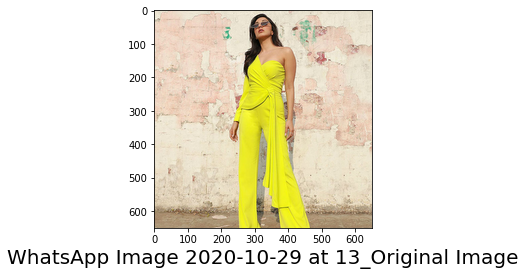

********* Predictions ***********


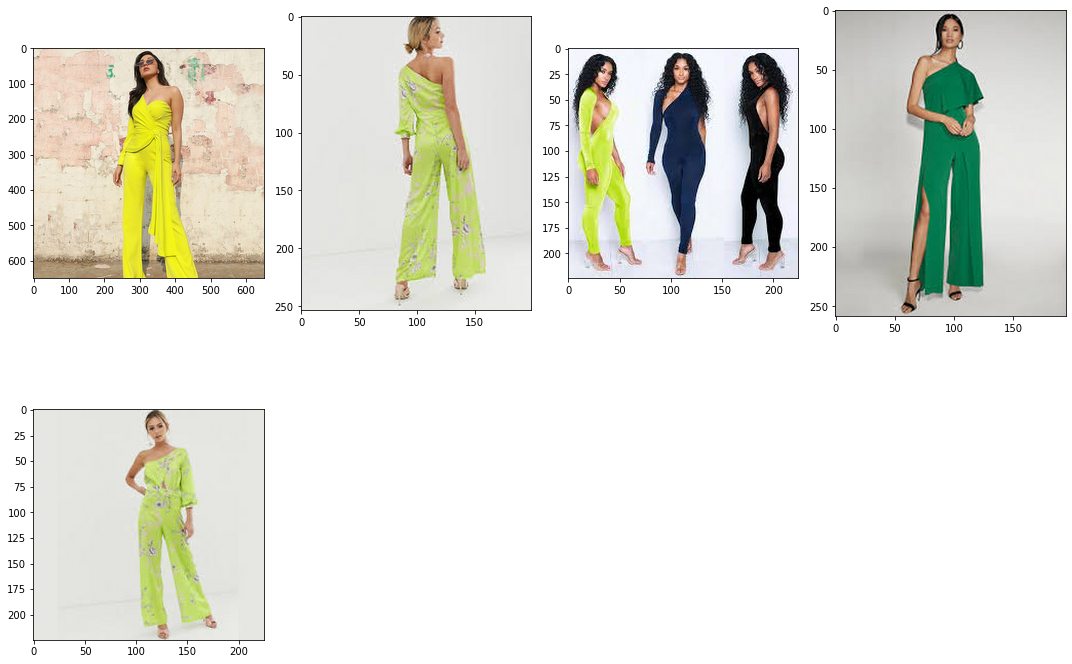

In [ ]:
test_img_compressed = pca.transform(test_img_features)
distances, indices = neighbors_pca_features.kneighbors(test_img_compressed)
print(indices.shape)
plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

###Now these would be packed into a sweet little box and presented to our customers
